In [16]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

# from polygon_api import PolygonAPI

In [17]:
sys.path.append(os.path.abspath(os.path.join("..", "src/modules")))

In [18]:
from os_lib import OSLib

In [19]:
# Get the API key from environment variables
load_dotenv()
api_key = os.getenv("POLYGON_API_KEY")

In [20]:
# Import custom lib
oslib = OSLib()

# Get the root path of the repository
repo_path = oslib.get_root_path()

In [21]:
# All tickers to fetch data for
stock_tick_path = f"{repo_path}/data/polygon/portfolio/stock_tickers.json"
idx_tick_path = f"{repo_path}/data/polygon/portfolio/idx_tickers.json"
with open(stock_tick_path) as s:
    tickers = json.load(s)

with open(idx_tick_path) as i:
    indices = json.load(i)

In [22]:
# Get the latest available data for intraday prices

source_path = f"{repo_path}/data/polygon/"
intraday_path = f"{source_path}intraday/mdlz/"

os.listdir(intraday_path)[-1].split(".")[0].split("_")[2:5]

['2025', '07', '03']

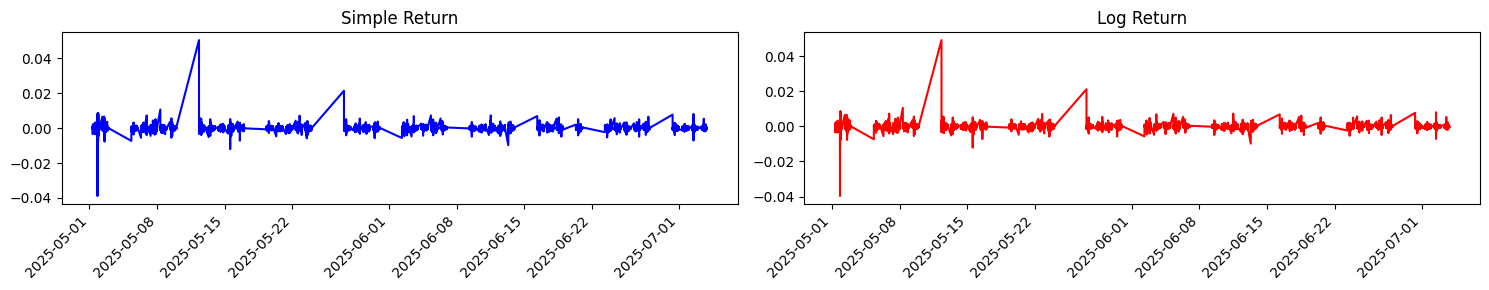

Simple Return: 0.00049 %
Log Return: 0.00046 %


In [23]:
source_path = f"{repo_path}/data/polygon/intraday/amzn/"

amzn = pd.read_parquet(source_path)
amzn.sort_index(inplace=True)

amzn["simple_return"] = (amzn["close"] / amzn["close"].shift(1)) - 1
amzn["log_return"] = np.log(amzn["close"] / amzn["close"].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn["simple_return"].plot(ax=axes[0], title="Simple Return", color="blue")
amzn["log_return"].plot(ax=axes[1], title="Log Return", color="red")

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn['log_return'].mean() * 100, 5)} %")

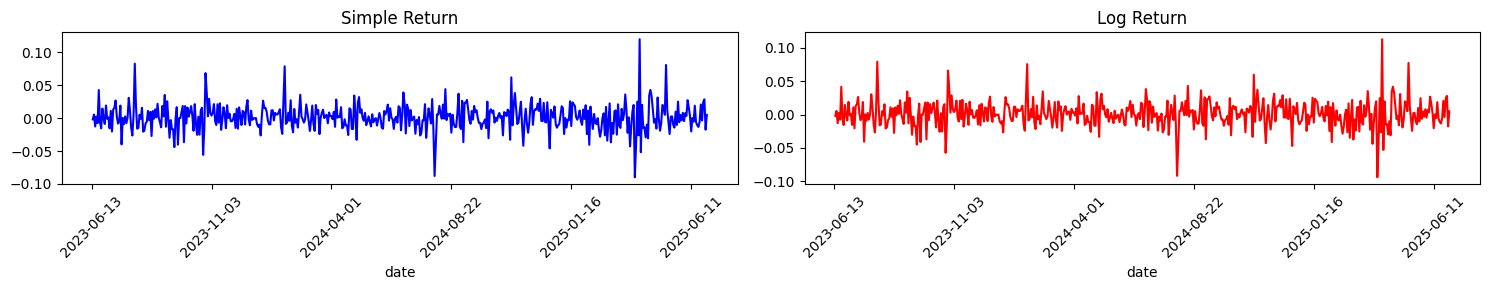

Simple Return: 0.12732 %
Log Return: 0.10803 %


In [24]:
source_path = f"{repo_path}/data/polygon/daily/amzn/"

amzn_daily = pd.read_parquet(source_path)
amzn_daily.index = pd.to_datetime(amzn_daily.index).strftime("%Y-%m-%d")

amzn_daily["simple_return"] = (amzn_daily["close"] / amzn_daily["close"].shift(1)) - 1

amzn_daily["log_return"] = np.log(amzn_daily["close"] / amzn_daily["close"].shift(1))

fig, axes = plt.subplots(1, 2, figsize=(15, 3), sharex=True)
amzn_daily["simple_return"].plot(ax=axes[0], title="Simple Return", color="blue")
amzn_daily["log_return"].plot(ax=axes[1], title="Log Return", color="red")

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

print(f"Simple Return: {round(amzn_daily['simple_return'].mean() * 100, 5)} %")
print(f"Log Return: {round(amzn_daily['log_return'].mean() * 100, 5)} %")

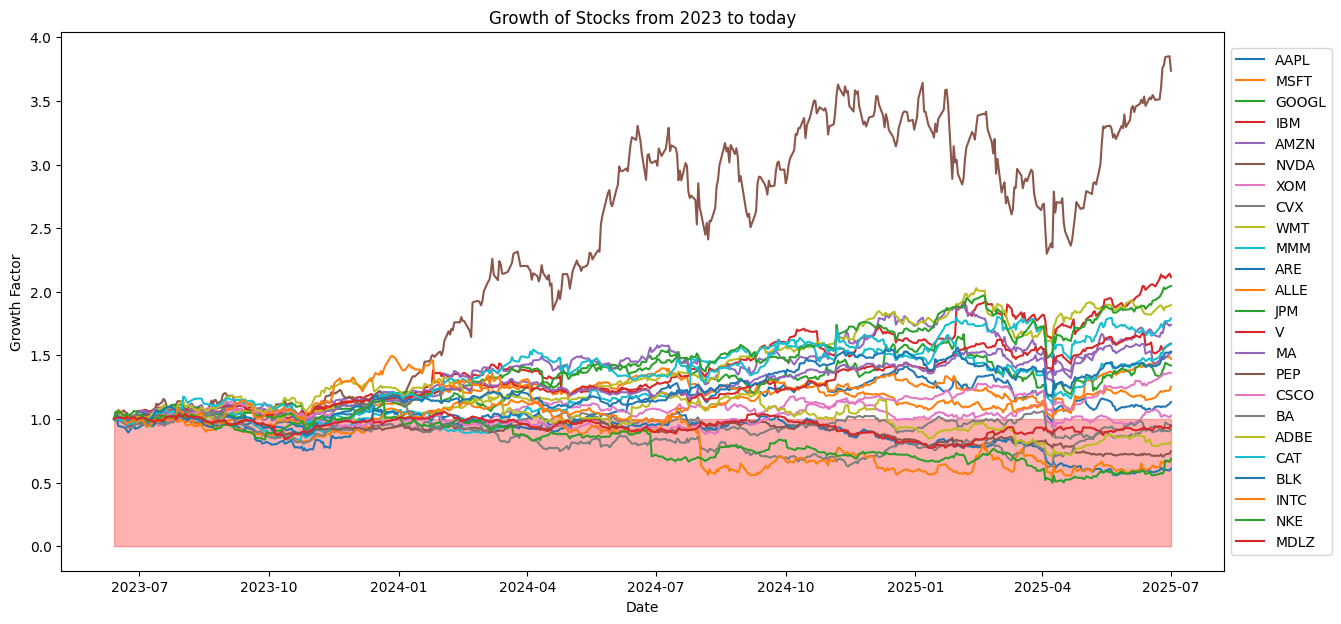

In [25]:
source_daily_path = f"{repo_path}/data/polygon/daily/"


df = pd.DataFrame()
simple_returns = pd.DataFrame()

plt.figure(figsize=(15, 7))

for ticker in tickers:
    df[ticker] = pd.read_parquet(source_daily_path + ticker.lower() + "/")["close"]
    simple_returns[ticker] = (df[ticker] / df[ticker].shift(1)) - 1
    growth = df[ticker] / df[ticker].iloc[0]
    plt.plot(df.index, growth, label=ticker.upper())

thres = 1.0

plt.fill_between(df.index, thres, 0, where=(df[ticker] > thres), color="red", alpha=0.3)  # type: ignore
plt.title("Growth of Stocks from 2023 to today")
plt.xlabel("Date")
plt.ylabel("Growth Factor")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

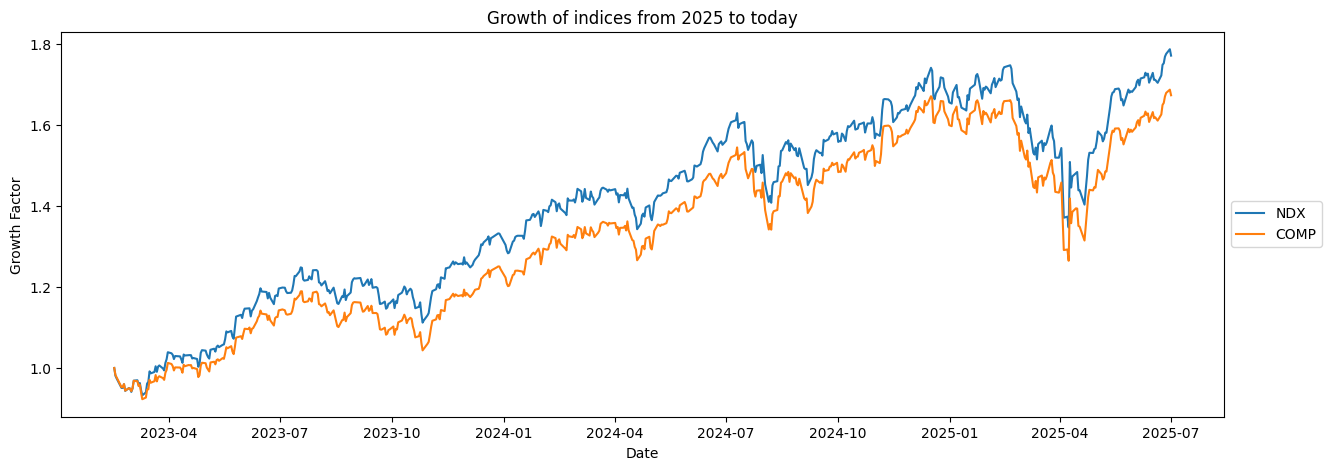

In [26]:
idx_source_daily_path = f"{repo_path}/data/polygon/daily/index/"

ind_df = pd.DataFrame()
ind_returns = pd.DataFrame()

plt.figure(figsize=(15, 5))

for tick in indices:
    ticker = tick.split(":")[1]  # Extract the ticker symbol from the index
    ind_df[ticker] = pd.read_parquet(idx_source_daily_path + ticker.lower() + "/")[
        "close"
    ]
    ind_returns[ticker] = (ind_df[ticker] / ind_df[ticker].shift(1)) - 1
    growth = ind_df[ticker] / ind_df[ticker].iloc[0]
    plt.plot(ind_df.index, growth, label=ticker.upper())

thres = 1.0

# plt.fill_between(ind_df.index, thres, where=(ind_df[ticker] > thres), color='red', alpha=0.3)
plt.title("Growth of indices from 2025 to today")
plt.xlabel("Date")
plt.ylabel("Growth Factor")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

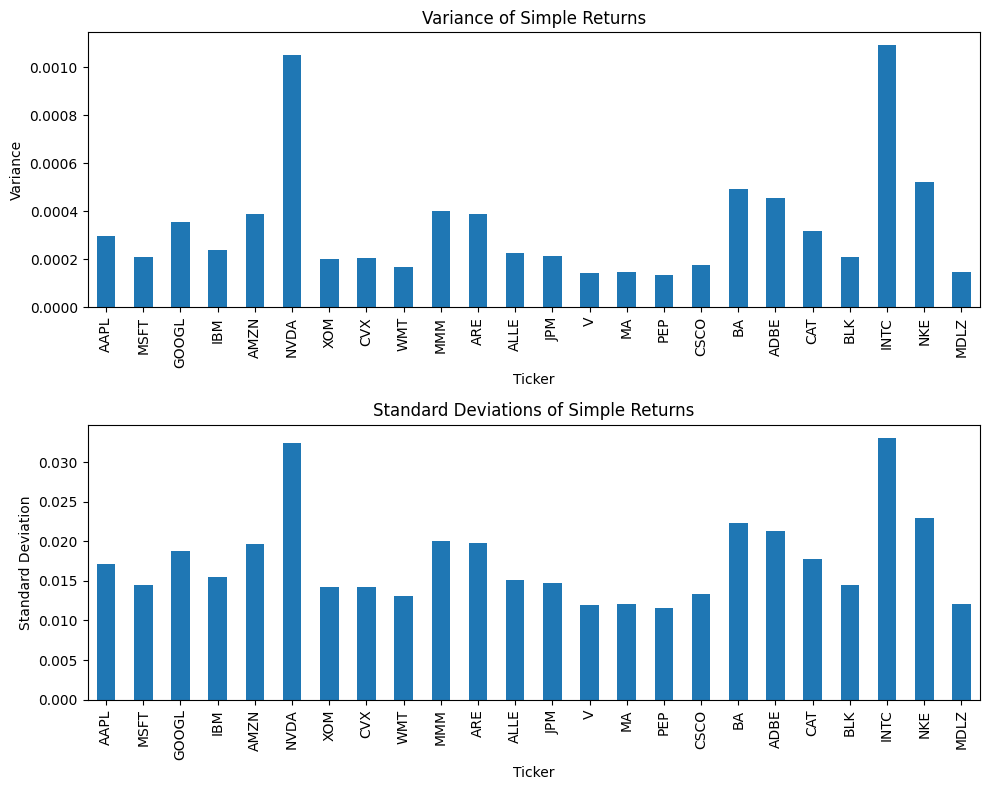

In [27]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
simple_returns.var().plot(kind="bar", ax=axs[0], title="Variance of Simple Returns")
axs[0].set_xlabel("Ticker")
axs[0].set_ylabel("Variance")

# Plot standard deviation of returns
simple_returns.std().plot(
    kind="bar", ax=axs[1], title="Standard Deviations of Simple Returns"
)
axs[1].set_xlabel("Ticker")
axs[1].set_ylabel("Standard Deviation")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<Axes: >

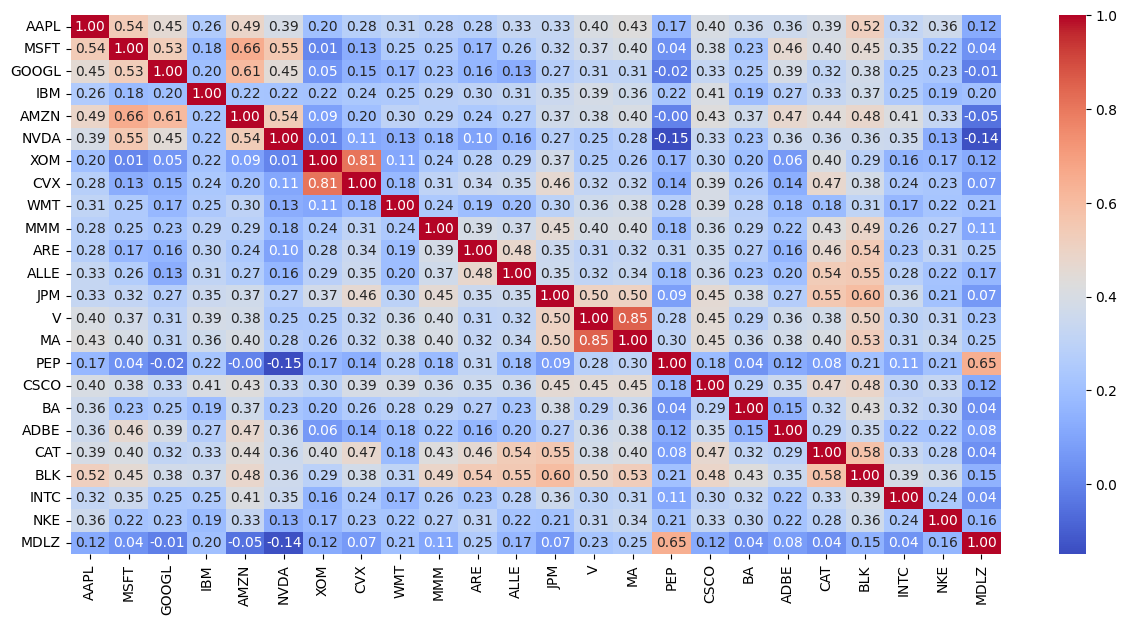

In [28]:
plt.figure(figsize=(15, 7))
sns.heatmap(simple_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")

## Comparing the stocks to the index values

<Axes: >

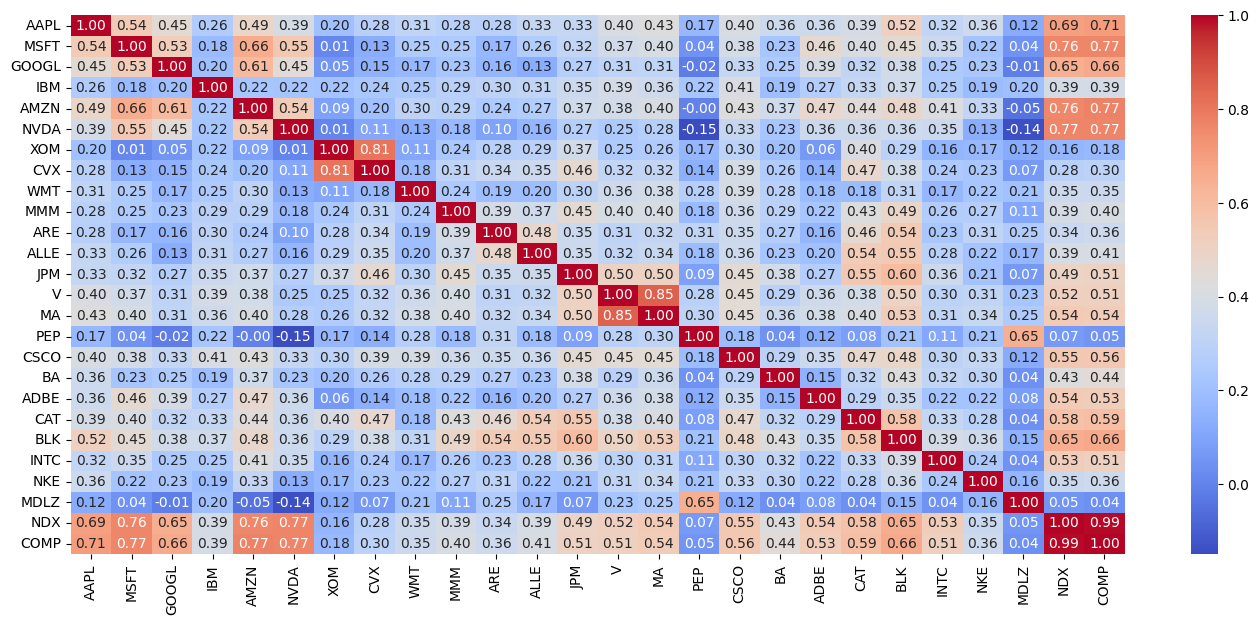

In [29]:
# Make a deep copy of the index returns dataframe and the simple returns dataframe
ind_returns_copy = ind_returns.copy()
simple_returns_copy = simple_returns.copy()

# Change the date format for index to match the stock data
ind_returns_copy.index = pd.to_datetime(ind_returns_copy.index).strftime("%Y-%m-%d")
simple_returns_copy.index = pd.to_datetime(simple_returns_copy.index).strftime(
    "%Y-%m-%d"
)

# Merge the stock and index dataframes
merged_df = pd.merge(
    simple_returns_copy,
    ind_returns_copy,
    how="inner",
    left_index=True,
    right_index=True,
    suffixes=("", "_idx"),
)

# Calculate the correlation between each stock and the indices
plt.figure(figsize=(17, 7))
sns.heatmap(merged_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

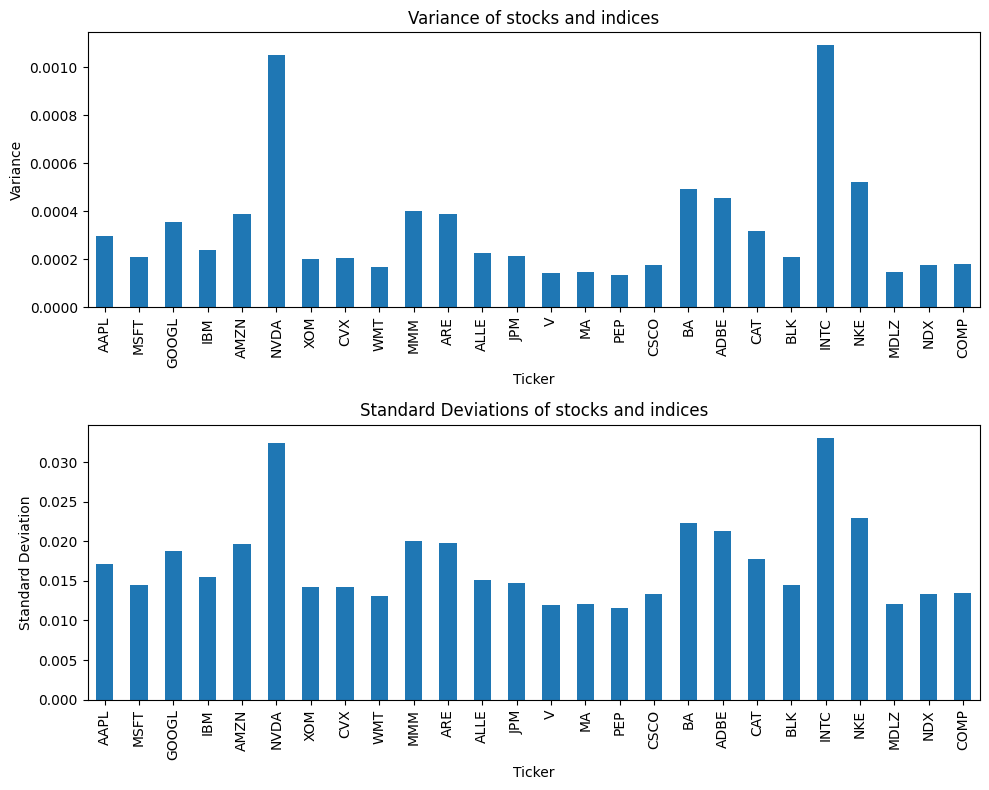

In [30]:
# Create a figure and two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot variance of returns
merged_df.var().plot(kind="bar", ax=axs[0], title="Variance of stocks and indices")
axs[0].set_xlabel("Ticker")
axs[0].set_ylabel("Variance")

# Plot standard deviation of returns
merged_df.std().plot(
    kind="bar", ax=axs[1], title="Standard Deviations of stocks and indices"
)
axs[1].set_xlabel("Ticker")
axs[1].set_ylabel("Standard Deviation")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [31]:
# Setting weight for equal distribution among tickers
equal_ws = np.array([1 / len(tickers) for _ in tickers])

In [32]:
pfolio_returns = simple_returns.dot(equal_ws)
pfolio_var = np.dot(equal_ws.T, np.dot(simple_returns.cov(), equal_ws))
print(f"Portfolio Returns: {round(pfolio_returns.mean() * 100, 5)} %")
print(f"Portfolio Variance: {pfolio_var}")

Portfolio Returns: 0.0643 %
Portfolio Variance: 9.950018801274785e-05


## Aggregate DataFrame

### Dividend Yield & Returns in 2024

In [33]:
source_dividends_path = f"{repo_path}/data/polygon/dividends/"
divs = pd.read_parquet(source_dividends_path)

# Calculate average dividend payout per share per ticker in 2024
sum_divs = (
    divs[(divs.index >= "2024-01-01") & (divs.index < "2025-01-01")][
        ["ticker", "cash_amount"]
    ]
    .groupby("ticker")
    .sum()
)
sum_divs = sum_divs.rename(columns={"cash_amount": "total_dividend_2024"})

In [34]:
def get_all_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            full_path = root + "/" + file
            file_paths.append(
                full_path.replace("\\", "/").replace("//", "/")
            )  # Normalize path separators
    return file_paths


all_files = get_all_file_paths(source_daily_path)

In [35]:
idx_2024_df = pd.DataFrame()

# Get the file paths for the indices
all_idx_files = get_all_file_paths(idx_source_daily_path)
idx_2024_files = [f for f in all_idx_files if "2024" in f]

for dir_path in idx_2024_files:
    ticker = (
        dir_path.split("/")[-1].split("_")[0].upper()
    )  # Extract the ticker symbol from the path
    df = pd.read_parquet(dir_path)
    df.index = pd.to_datetime(df.index).strftime("%Y-%m-%d")
    idx_2024_df[ticker] = df["close"]

idx_2024_df["market"] = idx_2024_df.mean(
    axis=1
)  # Calculate the market index as the mean of all indices
idx_2024_df.head()

,COMP,NDX,market
date,,,
2024-01-02,14765.939568,16543.937606,15654.938587
2024-01-03,14592.210616,16368.490570,15480.350593
2024-01-04,14510.300026,16282.012409,15396.156217
2024-01-05,14524.073216,16305.979061,15415.026139
2024-01-08,14843.768303,16649.874274,15746.821288


In [36]:
# Calculate the average share price for each ticker in 2024
avg_price_df = pd.DataFrame()

for file in all_files:
    if "2024" in file:
        ticker = file.split("/")[-1].split("_")[0].upper()
        avg_price_2024 = pd.read_parquet(file)
        avg_price_2024.index = pd.to_datetime(avg_price_2024.index).strftime("%Y-%m-%d")
        avg_price_2024 = avg_price_2024.join(idx_2024_df, how="left", rsuffix="_idx")
        avg_price_df.loc[ticker.upper(), "avg_price_2024"] = avg_price_2024[
            "close"
        ].mean()
        avg_price_df.loc[ticker.upper(), "returns_2024_%"] = (
            avg_price_2024["close"].iloc[-1] / avg_price_2024["close"].iloc[0]
        ) - 1
        avg_price_df.loc[ticker.upper(), "variance_2024"] = avg_price_2024[
            "close"
        ].var()
        avg_price_df.loc[ticker.upper(), "covariance_2024"] = avg_price_2024[
            "close"
        ].cov(avg_price_2024["market"])

In [37]:
# join the dfs on the index
agg_12mnd_df = avg_price_df.join(sum_divs, how="left")

# Calculate the dividend yield for each ticker
agg_12mnd_df["dividend_yield_%_2024"] = (
    agg_12mnd_df["total_dividend_2024"] / agg_12mnd_df["avg_price_2024"]
) * 100

## Beta, CAPM  and SHARPE-ratio of the stocks

Disclaimer: In this trial, I will use the two NASDAQ indices `Composite` (COMP) and `NASDAQ-100` (NDX) to represent the market. In the real world I would like to use many other indices like NYSE, Dow Jones, FTSE etc. but as of today I don't have these available.

In [38]:
risk_free_rate = 0.04

agg_12mnd_df["beta_2024"] = agg_12mnd_df["covariance_2024"] / (
    (
        agg_12mnd_df.loc["COMP", "variance_2024"]
        + agg_12mnd_df.loc["NDX", "variance_2024"]
    )
    / 2
)  # type: ignore
agg_12mnd_df["capm_2024"] = risk_free_rate + agg_12mnd_df["beta_2024"] * (
    np.mean(
        [
            agg_12mnd_df.loc["COMP", "returns_2024_%"],
            agg_12mnd_df.loc["NDX", "returns_2024_%"],
        ]
    )
    - risk_free_rate
)  # type: ignore
agg_12mnd_df["sharpe_2024"] = (
    agg_12mnd_df["returns_2024_%"] - risk_free_rate
) / np.sqrt(agg_12mnd_df["variance_2024"])

agg_12mnd_df.sort_values("capm_2024", ascending=False).head(10)

,avg_price_2024,returns_2024_%,variance_2024,covariance_2024,total_dividend_2024,dividend_yield_%_2024,beta_2024,capm_2024,sharpe_2024
COMP,17250.766701,0.307793,1.868897e+06,1.851923e+06,NaN,NaN,1.006966,0.290672,0.000196
NDX,19100.499518,0.270083,1.809329e+06,1.822139e+06,NaN,NaN,0.990771,0.286640,0.000171
BLK,867.082500,0.280907,9.350088e+03,1.085879e+05,20.40,2.352717,0.059044,0.054698,0.002491
NVDA,107.825438,1.787951,7.266971e+02,3.448800e+04,0.07,0.064920,0.018753,0.044668,0.064841
MA,474.129286,0.248122,9.351889e+02,3.085418e+04,2.64,0.556810,0.016777,0.044176,0.006806
AAPL,207.205913,0.348955,6.504026e+02,3.080618e+04,0.99,0.477786,0.016751,0.044170,0.012114
CAT,350.250714,0.239315,9.196919e+02,2.936423e+04,5.42,1.547463,0.015967,0.043975,0.006572
JPM,205.201111,0.393015,4.545761e+02,2.657148e+04,4.60,2.241703,0.014448,0.043597,0.016557
MMM,108.840254,0.403561,4.267759e+02,2.174104e+04,3.61,3.316788,0.011821,0.042943,0.017599
IBM,193.956389,0.361176,4.621645e+02,2.127681e+04,6.67,3.438917,0.011569,0.042880,0.014940


In [39]:
daily_returns_path = f"{repo_path}/data/polygon/portfolio/portfolio_returns.parquet"
combined_df = pd.read_parquet(daily_returns_path)

In [40]:
# Get the column name of all columns ending with _1yr_returns
stock_return_cols = [
    col
    for col in combined_df.columns
    if col.endswith("_1d_rtns")
    if not col.startswith("i_")
]
stock_close_cols = [
    col
    for col in combined_df.columns
    if col.endswith("_close")
    if not col.startswith("i_")
]
market_return_cols = [
    col
    for col in combined_df.columns
    if col.endswith("_1d_rtns")
    if col.startswith("i_")
]
market_close_cols = [
    col for col in combined_df.columns if col.endswith("_close") if col.startswith("i_")
]
all_return_cols = [col for col in combined_df.columns if col.endswith("_1d_rtns")]
all_close_cols = [col for col in combined_df.columns if col.endswith("_close")]